<a href="https://colab.research.google.com/github/tpessoa-dev/deep-learning/blob/main/Exemplo_Pr%C3%A9_Processamento_ELM_Dataset_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sklearn_extensions

  Created wheel for sklearn-extensions: filename=sklearn_extensions-0.0.2-py2.py3-none-any.whl size=24578 sha256=71737e0349e513d0c81fd64d60aa57e4c22b9d23dc13093a954e771629fb037c
  Stored in directory: /root/.cache/pip/wheels/b5/26/b2/09100728168b45e4de834b943a588028744fdfaa9ac979ffb2
Successfully built sklearn-extensions


In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn_extensions.extreme_learning_machines.elm import GenELMClassifier
from sklearn_extensions.extreme_learning_machines.random_layer import RBFRandomLayer, MLPRandomLayer

A primeira coisa que vamos fazer é ler o conjunto de dados usando a função read_csv() dos Pandas. 
Colocaremos esses dados em um DataFrame do Pandas, chamado "titanic", e nomearemos cada uma das colunas.

In [ ]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


VARIABLE DESCRIPTIONS:
<ol>
<li>Survived - Survival (0 = No; 1 = Yes);</li>
<li>Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd);</li>
<li>Name - Name;</li>
<li>Sex - Sex;</li>
<li>Age - Age;</li>
<li>SibSp - Number of Siblings/Spouses Aboard;</li>
<li>Parch - Number of Parents/Children Aboard;</li>
<li>Ticket - Ticket Number;</li>
<li>Fare - Passenger Fare (British pound);</li>
<li>Cabin - Cabin;</li>
<li>Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton);</li>
</ol>

Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.
Para ter certeza de que é uma variável binária, vamos usar a função countplot() do Seaborn.

Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.
Para ter certeza de que é uma variável binária, vamos usar a função countplot () do Seaborn.

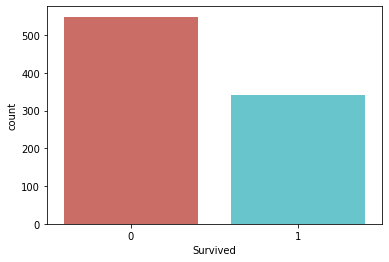

In [ ]:
sb.countplot(x='Survived',data=titanic, palette='hls')

### Checking for missing values
É fácil checar missing values usando método isnull() com o método sum(), o número retornado condiz com a quantidade True para o teste, ou seja, quantidade de valores nulos nas variaveis

In [ ]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Ok, então existem 891 linhas no dataframe. Cabin é quase todo composto por missing values, então podemos eliminar essa característica! Mas e quanto à idade? A age parece um preditor relevante para a sobrevivência, certo? Nós queremos manter as variáveis, mas tem 177 missing values. Precisamos encontrar uma maneira de nos aproximarmos desses valores em falta!

E quanto ao nome de uma pessoa, número do bilhete e número de identificação do passageiro? Eles são irrelavantes para prever a capacidade de sobrevivência. E, como você se lembra, a variável cabine é quase todoa com missing values!!

In [ ]:
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
titanic_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Agora, o dataframe foi reduzido para apenas variáveis relevantes, mas agora precisamos lidar com os valores ausentes na variável age.

### Imputing missing values
Vejamos como a idade do passageiro está relacionada à sua classe como passageiro no barco.

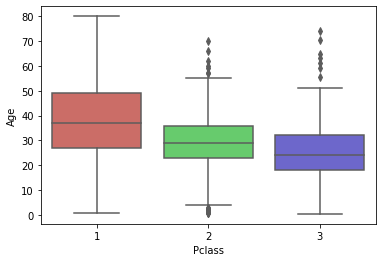

In [ ]:
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

Falando mais ou menos, poderíamos dizer que quanto mais jovem é um passageiro, mais provável é que ele esteja na 3ª classe. Quanto mais velho for um passageiro, maior a probabilidade de estarem na 1ª classe. Portanto, há um relacionamento frouxo entre essas variáveis. Então, vamos escrever uma função que se aproxime da idade dos passageiros, com base em sua classe. Na caixa, parece que a idade média dos passageiros de 1ª classe é de cerca de 37 anos, os passageiros de 2ª classe são 29 e os passageiros de 3ª classe são 24.

Então, vamos escrever uma função que encontre cada valor nulo na variável Age e, para cada nulo, verifique o valor da Pclass e atribua um valor de idade de acordo com a idade média dos passageiros nessa classe.

In [ ]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Após definir a função, vamos executar apenas para os valores nulos de Age

In [ ]:
titanic_data[['Age', 'Pclass']]

,Age,Pclass
0,22.0,3
1,38.0,1
2,26.0,3
3,35.0,1
4,35.0,3
...,...,...
886,27.0,2
887,19.0,1
888,NaN,3
889,26.0,1


In [ ]:
titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    24.0
889    26.0
890    32.0
Length: 891, dtype: float64

In [ ]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

Existem ainda 2 valores nulos na variável Embarked. Podemos eliminar esses dois registros sem perder muitas informações importantes do nosso conjunto de dados, então faremos isso.

In [ ]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [ ]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Convertendo variaveis categóricas com one-hot-enconding (via pandas usa-se a função get_dummies)
![Exemplo de One Hoting Encoding](https://telescopeinstorage.blob.core.windows.net/datasets/onehotencoding.jpg)

In [ ]:
aux = pd.get_dummies(titanic_data['Sex'],drop_first=False)
aux.head()

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [ ]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [ ]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [ ]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [ ]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Agora temos um conjunto de dados com todas as variáveis no formato correto!
### Validando independencia entre as variáveis

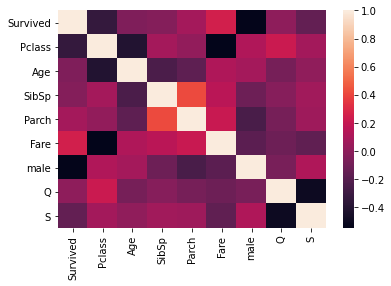

In [ ]:
sb.heatmap(titanic_dmy.corr())  

Fare e Pclass não sao independentes uma com a outra, entao vamos excluí-las.

In [ ]:
titanic_dmy.drop(['Pclass'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,0,35.0,0,0,8.0500,1,0,1


O mesmo processo vale para as características C e Q

In [ ]:
titanic_dmy.drop(['Q'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,Fare,male,S
0,0,22.0,1,0,7.2500,1,1
1,1,38.0,1,0,71.2833,0,0
2,1,26.0,0,0,7.9250,0,1
3,1,35.0,1,0,53.1000,0,1
4,0,35.0,0,0,8.0500,1,1


### Agora Vamos Classificar!

1º: Separar o conjunto em variavel resposta e características de treinamento

In [ ]:
X = titanic_dmy.iloc[:,[1,2,3,4,5,6]].values
y = titanic_dmy.iloc[:,0].values

In [ ]:
X.shape

(889, 6)

In [ ]:
X

array([[22.    ,  1.    ,  0.    ,  7.25  ,  1.    ,  1.    ],
       [38.    ,  1.    ,  0.    , 71.2833,  0.    ,  0.    ],
       [26.    ,  0.    ,  0.    ,  7.925 ,  0.    ,  1.    ],
       ...,
       [24.    ,  1.    ,  2.    , 23.45  ,  0.    ,  1.    ],
       [26.    ,  0.    ,  0.    , 30.    ,  1.    ,  0.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ,  1.    ,  0.    ]])

In [ ]:
y

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

Normalização do Conjunto

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X

array([[-0.53167023,  0.43135024, -0.47432585, -0.50023975,  0.73534203,
         0.61679395],
       [ 0.68023223,  0.43135024, -0.47432585,  0.78894661, -1.35991138,
        -1.62128697],
       [-0.22869462, -0.47519908, -0.47432585, -0.48664993, -1.35991138,
         0.61679395],
       ...,
       [-0.38018243,  0.43135024,  2.00611934, -0.17408416, -1.35991138,
         0.61679395],
       [-0.22869462, -0.47519908, -0.47432585, -0.0422126 ,  0.73534203,
        -1.62128697],
       [ 0.22576881, -0.47519908, -0.47432585, -0.49017322,  0.73534203,
        -1.62128697]])

Agora dividir em treino e teste (teste com 30%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [ ]:
X_train.shape

(622, 6)

#### Cria o Modelo de Rede Neural ELM


In [ ]:
nh = 20

#Primeiro EML baseado em MPL com função de ativação sigmoid
srhl_sigmoid = MLPRandomLayer(n_hidden=nh, activation_func='sigmoid', random_state=0)
elm_model = GenELMClassifier(hidden_layer=srhl_sigmoid)
elm_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


GenELMClassifier(binarizer=LabelBinarizer(neg_label=-1, pos_label=1,
                                          sparse_output=False),
                 hidden_layer=MLPRandomLayer(activation_args=None,
                                             activation_func='sigmoid',
                                             biases=None, n_hidden=20,
                                             random_state=0, weights=None),
                 regressor=None)

In [ ]:
score = elm_model.score(X_test, y_test)
print(score)

0.7865168539325843


In [ ]:
#Primeiro EML baseado em rede RBF
srhl_rbf = RBFRandomLayer(n_hidden=nh, rbf_width=0.1, random_state=0)
elm_model = GenELMClassifier(hidden_layer=srhl_rbf)
elm_model.fit(X_train, y_train)

In [ ]:
score = elm_model.score(X_test, y_test)
print(score)

0.7902621722846442
